# Fourth exercise (Chapter 6)

In this exercise we consider Chapter 6 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset. We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization


Apart from the MNIST dataset and the mnist_loader.py file, both available on ILIAS, we also need a Python library called Numpy, for doing fast linear algebra. If you don't already have Numpy installed, please install it.

In [2]:
import pickle
import gzip
import pdb
import numpy as np
from IPython.core.debugger import set_trace

def load_data():

    f = gzip.open('data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_datawrapper():

    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]     # flatten images to 1 dim vectors
    print(training_inputs[1].shape)
    training_results = [vectorized_result(y) for y in tr_d[1]]       # one hot encode labels - only for training
    training_data = zip(training_inputs, training_results)           # make list of tuples inputs / label
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])                # also flattened inputs, but lables not one hot encoded
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (list(training_data), list(validation_data), list(test_data))
    # training_data is list of tuples of ndarrays

def vectorized_result(j):

    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


In [10]:
import random
import mnist_loader
# Third-party libraries
import numpy as np

## Sigmoid Function

Complete the Miscellaneous functions where it is needed by applying the definiton of sigmoid function and computing its derivative.

In [5]:
#### Miscellaneous functions

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):      # gemeral case, where z can be a nxd matrix
    dz = np.zeros_like(z)  # initialise matrix
    dz = sigmoid(z) * (1.0 - sigmoid(z))    # 1.0+ is broadcasted,  " * "   is element-wise
    return dz

def vectorized_result(j):  # 10-dimn one hot encoder
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

Generate 100 points in the interval [-4,+4], compute and plot the sigmoid function.

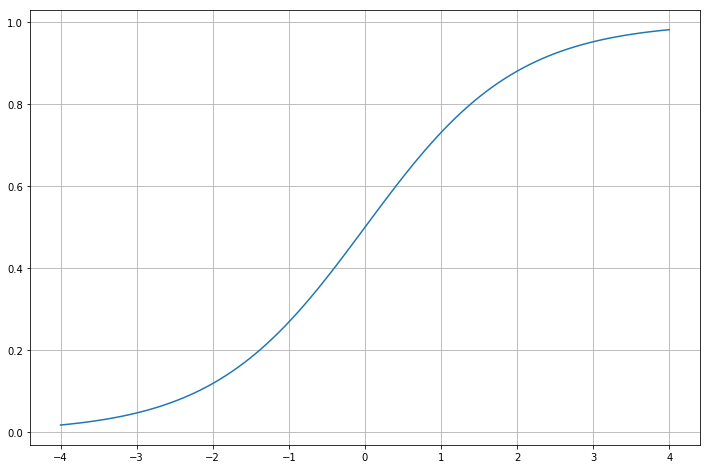

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

x_vals = np.linspace(-4.0, 4.0, num=101)
# y_vals = np.zeros_like(x_vals)
y_vals = [sigmoid(y) for y in x_vals]

# print(y_vals)

plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_vals, label='sigmoid function')
plt.grid(True)
# plt.xlabel("x values")
# plt.legend(loc='best')


## Cost Functions

The following classes represent two different cost functions and their derivatives: the quadratic and the cross entropy cost function. Plese, fill in the code where it is needed by applying the definitions of quadratic and cross entropy cost function and computing their derivatives. 

In [7]:
# Define the Quadratic and the Cross-Entropy cost functions

'''
NOTATION NOTE:  
z is the output of layer i+1 before the application of the non-linearity,
a the output of the network, where a = sigmoid(z),
and y the vector of the labels.
'''

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        """
        return 0.5*np.linalg.norm(a-y)**2
        

    @staticmethod
    def delta(z, a, y):
        """Return the derivative of the cost function wrt z. 
           Recall that a=sigmoid(z).
        """
        # chain rule:dL/dz = dL/da * da/dz where L = 0.5*(a-y)**2 and a = sigma(z) 
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):    # y € {0,1}
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        
        return a - y   # math short_cut (GoodFellow p. 215)   ? /n_samples ??

## Network Implementation

The centerpiece of this implementation of a feedforward neural network is a Network class, which we use to represent a neural network. Please, complete the code and implement the missing parts, by following the instructions in the comments.

In [8]:
'''
NOTATION NOTE: 
z=w*activation+b, 
where w is the weight matrix wrt the connections between layer i and layer i+1,
b is the bias vector of the layer i+1,
and activation is the output vector of the layer i, in particular activation=sigmoid(z).
'''

class Network(object):

    def __init__(self, sizes, cost=QuadraticCost):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        # why biases gaussian ? not rather a small positive ? 
        self.num_layers = len(sizes)   # done
        self.sizes = sizes
        # list of np.arrays of respective layer sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]   # all layers except first one (input layer no bias)
        self.weights = [np.random.randn(y, x)                      # dim(w) for each layer layer_size x previous_size
                        for x, y in zip(sizes[:-1], sizes[1:])]    # 1,2 / 2,3 / ...
        # if cost == QuadraticCost:
        #     self.cost = QuadraticCost
        # elif cost == CrossEntropyCost:
        #     self.cost = QuadraticCost
        self.cost = cost    

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input.
        """
        activation = a
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w,activation) + b
            activation = sigmoid(z)
        return activation

    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            filename_config=None,
            filename_results=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        '''NOTATION NOTE: evaluationa_data is the part of the data used for 
        evaluating the performances: in particular it could be either validation or 
        test set. n_data refers to the size of the evaluation data.'''
        
        if evaluation_data: 
            n_data = len(evaluation_data)   # check if this works ??
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
       
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
                
            print ("Epoch {} complete".format(j))
            
            if monitor_training_cost:
                cost = self.total_cost(training_data)
                training_cost.append(cost)
                print ("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print ("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, convert=True)
                evaluation_cost.append(cost)
                print ("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy

    def update_mini_batch(self, mini_batch, eta):    
    # mini_batch is slice from training_data, which is list of 2-tuples of nd-arrays
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        # list of arrays with zeros with given shapes of layers (actually self.biases filled with zeros)
        nabla_b = [np.zeros(b.shape) for b in self.biases]   # list of arrays with zeroswith given shapes of layers
        nabla_w = [np.zeros(w.shape) for w in self.weights]  # # list of nd_arrays with zeros 
        for x, y in mini_batch:    # enumerates through x, y tuples of all samples of minibatch
            # each sample generates individual gradient
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)  # gradients of weights 
            # for each sample update nabla_b by gradient 
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]  
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # update weights by mean of updates for all samples multiplied by steplength
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                        for b, nb in zip(self.biases, nabla_b)]
       
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer, here store input x as first layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            '''NOTATION NOTE: z is the output of a layer before the application of the 
            non-linearity (in this example the sigmoid function), while activation is after 
            the application of the non-linearity.'''
            z = np.dot(w,activation) + b # here x is single sample, calculate output Z of this layer
            zs.append(z)   # build up list of stored outputs z going forward
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        # call "delta" method of cost object (either cross entropy or MSE) for last layer
        delta = (self.cost).delta(zs[-1], activations[-1], y) # dL/dz where z ist output of last layer. 
        # Takes into account cost function and output function (coming AFTER last layer, additional non-linearity)
        nabla_b[-1] = delta  # assign dL/dz to stored gradients
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):  # counting backwards
            z = zs[-l]   # -l counts list fom the end
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp   # wT.d
            nabla_b[-l] = delta                                          # dL/db
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))     # labels as digits 1 ...10
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)                # labels one hot encoded
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        return cost       

## Experiments

Load the data by using the load_datawrapper() function in the mnist_loader.py file, and measure the number of training, validation and test examples. In this exercise, we will not use the validation set, but only training and test sets. Secondly, build a network with an input layer of sigmoid neurons whose number is given by the number of features of a training example, one hidden layer with 10 sigmoid neurons, and a final output layer of sigmoid neurons whose number is given by the number of classes. Then train it for 30 epochs using the quadratic cost function as objective function for the optimization problem and SGD method as solver, and evaluate the performance on the test data. Use a learing rate of 0.1 and a batch size of 10. Compute and print the best test accuracy achieved.

In [9]:
import mnist_loader

training_data, validation_data, test_data = load_datawrapper()

num_training_examples = len(training_data)
num_validation_examples = len(validation_data)
num_test_examples = len(test_data)

num_features = len(training_data[0][0])
num_classes = len(training_data[0][1])
# set_trace()
net = Network([num_features,10,num_classes], QuadraticCost)   
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(training_data, 30, 10, 0.1,
            evaluation_data=test_data,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True)

#    def SGD(self, training_data, epochs, mini_batch_size, eta,

ModuleNotFoundError: No module named 'mnist_loader'

Let's now try to increase the learning rate value to 3.0: train the network with the same hyparameter setting as in the previous point except for the learning rate. Compute and print the best test accuracy achieved. How do the performances change?

In [8]:
net = Network([num_features,10,num_classes], QuadraticCost)   # new initialisation of network
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(training_data, 30, 10, 3,
            evaluation_data=test_data,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True)

(784, 1)
Epoch 0 complete
Cost on training data: 0.0968098477292502
Accuracy on training data: 43883 / 50000
Cost on evaluation data: 0.09314476145849032
Accuracy on evaluation data: 8820 / 10000
Epoch 1 complete
Cost on training data: 0.08254069086459158
Accuracy on training data: 44876 / 50000
Cost on evaluation data: 0.08329341835021906
Accuracy on evaluation data: 8955 / 10000
Epoch 2 complete
Cost on training data: 0.07624406850606273
Accuracy on training data: 45312 / 50000
Cost on evaluation data: 0.07791869496572652
Accuracy on evaluation data: 9053 / 10000
Epoch 3 complete
Cost on training data: 0.07708489432881598
Accuracy on training data: 45230 / 50000
Cost on evaluation data: 0.07889809292113865
Accuracy on evaluation data: 9034 / 10000
Epoch 4 complete
Cost on training data: 0.07093178575761526
Accuracy on training data: 45656 / 50000
Cost on evaluation data: 0.07444883458942675
Accuracy on evaluation data: 9078 / 10000
Epoch 5 complete
Cost on training data: 0.0714017830

The performance is better at a learning rate of 3.0. The Network learns fast, up to 9.158 / 10.000 after 8 epochs, where it reaches a maximum. At the learning rate of 0.1 the network learns much slower, and reaches an accuracy of 8.781 after 30 epochs - but was still increasing its performance at this point.   

Set the learning rate to 3.0. Let's now try to increase the number of hidden neurons to 30: are the performances changing? How? 

In [13]:
net = Network([num_features,30,num_classes], QuadraticCost)   # new initialisation of network
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(training_data, 30, 10, 3,
            evaluation_data=test_data,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True)

Epoch 0 complete
Cost on training data: 0.07440417592739684
Accuracy on training data: 45558 / 50000
Cost on evaluation data: 0.07155727482799346
Accuracy on evaluation data: 9144 / 10000
Epoch 1 complete
Cost on training data: 0.062521605062724
Accuracy on training data: 46290 / 50000
Cost on evaluation data: 0.06519367556773162
Accuracy on evaluation data: 9192 / 10000
Epoch 2 complete
Cost on training data: 0.055038779082742864
Accuracy on training data: 46739 / 50000
Cost on evaluation data: 0.05871512672010918
Accuracy on evaluation data: 9273 / 10000
Epoch 3 complete
Cost on training data: 0.05120052885780683
Accuracy on training data: 46970 / 50000
Cost on evaluation data: 0.0547207713245623
Accuracy on evaluation data: 9335 / 10000
Epoch 4 complete
Cost on training data: 0.04784482472451635
Accuracy on training data: 47163 / 50000
Cost on evaluation data: 0.05362554176584038
Accuracy on evaluation data: 9353 / 10000
Epoch 5 complete
Cost on training data: 0.04658865969614499
Ac

with 30 neurons in the hidden layer instead of 10, the networks runs slower (by a factor of about 2).
It reaches a better performance of about 95% on the test data after 20 epochs, remains on this level after further training.

We would conclude, that with 10 neurons in the hidden layer the capacity of the network was too low. 

Based on experiences in other tests (Lab Course) we would assume, that an optimum for this configuration (fully connected layers) would be reached a much larger capacity, at 2 or 3 hidden layers, and several 100 neurons per layer. 
A further leap in performance can be reached with convolutional networks.

How do the performances change if we set the learning rate value back to 0.1? What can you conclude from that?

In [10]:
net = Network([num_features,30,num_classes], QuadraticCost)   # new initialisation of network
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(training_data, 30, 10, 0.1,
            evaluation_data=test_data,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True)

Epoch 0 complete
Cost on training data: 0.3576758271487596
Accuracy on training data: 21339 / 50000
Cost on evaluation data: 0.352752895735201
Accuracy on evaluation data: 4403 / 10000
Epoch 1 complete
Cost on training data: 0.2955229821016773
Accuracy on training data: 27641 / 50000
Cost on evaluation data: 0.28847187276592906
Accuracy on evaluation data: 5659 / 10000
Epoch 2 complete
Cost on training data: 0.2077386219204613
Accuracy on training data: 36517 / 50000
Cost on evaluation data: 0.20104220158514277
Accuracy on evaluation data: 7412 / 10000
Epoch 3 complete
Cost on training data: 0.16759037091600815
Accuracy on training data: 39636 / 50000
Cost on evaluation data: 0.1608282476801509
Accuracy on evaluation data: 8041 / 10000
Epoch 4 complete
Cost on training data: 0.14697354652034156
Accuracy on training data: 40922 / 50000
Cost on evaluation data: 0.13995712555941622
Accuracy on evaluation data: 8288 / 10000
Epoch 5 complete
Cost on training data: 0.13340706368705277
Accura

As expected, and as with 10 layers, the network learns goes much slower, and reaches an accuracy of 9.137 / 10.000 on the test set after 30 epochs, where it is still slightly increasing, and thus seems to be still in an underfitting region.

## Generalization

The rest of this exercise will be dedicated to some considerations about generalization: for this scope train a network with 30 hidden neurons, a mini-batch size of 10, a learning rate of 0.5 and the cross entropy cost function as objective function of our optimization problem. Instead of training the network on the full training set, use only the first 1000 training examples: using this restricted set will make the problem of generalization much more evident. Since we are not using many training examples, train your network for 300 epochs instead of only 30. 

In [16]:
short_training_data = training_data[:1000]

net = Network([num_features,30,num_classes], CrossEntropyCost)   # new initialisation of network
t_cost, t_accuracy, e_cost, e_accuracy = net.SGD(short_training_data, 300, 10, 0.5,
           evaluation_data=test_data,
           monitor_evaluation_cost=True,
           monitor_evaluation_accuracy=True,
           monitor_training_cost=True,
           monitor_training_accuracy=True)

Epoch 0 complete
Cost on training data: 1.8926967455395813
Accuracy on training data: 629 / 1000
Cost on evaluation data: 2.0016165179509495
Accuracy on evaluation data: 6035 / 10000
Epoch 1 complete
Cost on training data: 1.4036790249021944
Accuracy on training data: 774 / 1000
Cost on evaluation data: 1.6227161464519473
Accuracy on evaluation data: 6933 / 10000
Epoch 2 complete
Cost on training data: 1.3078675223516134
Accuracy on training data: 756 / 1000
Cost on evaluation data: 1.5962698022249704
Accuracy on evaluation data: 6907 / 10000
Epoch 3 complete
Cost on training data: 1.0647779770134576
Accuracy on training data: 823 / 1000
Cost on evaluation data: 1.461537456154789
Accuracy on evaluation data: 7324 / 10000
Epoch 4 complete
Cost on training data: 0.8574006358039128
Accuracy on training data: 872 / 1000
Cost on evaluation data: 1.271765945932866
Accuracy on evaluation data: 7761 / 10000
Epoch 5 complete
Cost on training data: 0.7605925744139591
Accuracy on training data: 8

Accuracy on evaluation data: 8295 / 10000
Epoch 45 complete
Cost on training data: 0.07509282305793825
Accuracy on training data: 997 / 1000
Cost on evaluation data: 1.2152708841370696
Accuracy on evaluation data: 8291 / 10000
Epoch 46 complete
Cost on training data: 0.07251032772574811
Accuracy on training data: 997 / 1000
Cost on evaluation data: 1.2216094698911604
Accuracy on evaluation data: 8289 / 10000
Epoch 47 complete
Cost on training data: 0.07006136166884197
Accuracy on training data: 998 / 1000
Cost on evaluation data: 1.213101167455026
Accuracy on evaluation data: 8302 / 10000
Epoch 48 complete
Cost on training data: 0.06956482386773451
Accuracy on training data: 998 / 1000
Cost on evaluation data: 1.2297407662550441
Accuracy on evaluation data: 8309 / 10000
Epoch 49 complete
Cost on training data: 0.06770660046412758
Accuracy on training data: 999 / 1000
Cost on evaluation data: 1.2220704253801933
Accuracy on evaluation data: 8294 / 10000
Epoch 50 complete
Cost on training

Cost on training data: 0.027935026387770023
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3384312987389413
Accuracy on evaluation data: 8336 / 10000
Epoch 90 complete
Cost on training data: 0.027520057035659046
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3390209333704393
Accuracy on evaluation data: 8335 / 10000
Epoch 91 complete
Cost on training data: 0.02707057240182519
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3361159793716617
Accuracy on evaluation data: 8352 / 10000
Epoch 92 complete
Cost on training data: 0.026908579277154027
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3431428831928833
Accuracy on evaluation data: 8338 / 10000
Epoch 93 complete
Cost on training data: 0.026271300125560025
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.3410496002235825
Accuracy on evaluation data: 8326 / 10000
Epoch 94 complete
Cost on training data: 0.025916361778051455
Accuracy on training d

Cost on training data: 0.016109626532062115
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4090143895441656
Accuracy on evaluation data: 8343 / 10000
Epoch 134 complete
Cost on training data: 0.0159048018367413
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4134463870890408
Accuracy on evaluation data: 8335 / 10000
Epoch 135 complete
Cost on training data: 0.015712718936007182
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4143538043863977
Accuracy on evaluation data: 8342 / 10000
Epoch 136 complete
Cost on training data: 0.01554479905567191
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4149737717715285
Accuracy on evaluation data: 8337 / 10000
Epoch 137 complete
Cost on training data: 0.01540785042080258
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4134145957132696
Accuracy on evaluation data: 8334 / 10000
Epoch 138 complete
Cost on training data: 0.015206591628865226
Accuracy on training

Cost on training data: 0.010886102203645626
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4604853075522104
Accuracy on evaluation data: 8344 / 10000
Epoch 178 complete
Cost on training data: 0.01080270539717173
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4620631371068922
Accuracy on evaluation data: 8338 / 10000
Epoch 179 complete
Cost on training data: 0.010728251371394208
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4634727414431987
Accuracy on evaluation data: 8337 / 10000
Epoch 180 complete
Cost on training data: 0.010648912133601253
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.46336573700344
Accuracy on evaluation data: 8341 / 10000
Epoch 181 complete
Cost on training data: 0.01057307782948732
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4653685362884397
Accuracy on evaluation data: 8338 / 10000
Epoch 182 complete
Cost on training data: 0.010500056187498028
Accuracy on training

Accuracy on evaluation data: 8354 / 10000
Epoch 221 complete
Cost on training data: 0.008244874648319122
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.4998029686568548
Accuracy on evaluation data: 8351 / 10000
Epoch 222 complete
Cost on training data: 0.008199326781387618
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.500646066831418
Accuracy on evaluation data: 8350 / 10000
Epoch 223 complete
Cost on training data: 0.008155703585347004
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5005571419709332
Accuracy on evaluation data: 8350 / 10000
Epoch 224 complete
Cost on training data: 0.008111087177368756
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5011535580825985
Accuracy on evaluation data: 8353 / 10000
Epoch 225 complete
Cost on training data: 0.008065216047262954
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5041285653917749
Accuracy on evaluation data: 8354 / 10000
Epoch 226 complete


Cost on evaluation data: 1.5293499447994974
Accuracy on evaluation data: 8357 / 10000
Epoch 265 complete
Cost on training data: 0.006617869702247422
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5309335903981192
Accuracy on evaluation data: 8360 / 10000
Epoch 266 complete
Cost on training data: 0.006587619372600061
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5318178290326798
Accuracy on evaluation data: 8355 / 10000
Epoch 267 complete
Cost on training data: 0.006557791106982866
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.531862258768394
Accuracy on evaluation data: 8359 / 10000
Epoch 268 complete
Cost on training data: 0.006528937554562834
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5323263717363775
Accuracy on evaluation data: 8357 / 10000
Epoch 269 complete
Cost on training data: 0.006498544914085173
Accuracy on training data: 1000 / 1000
Cost on evaluation data: 1.5339199446753713
Accuracy on evalu

Using the results from the previous point, generate one plot with training cost vs epochs and one with test accuracy vs epochs. The training cost looks encouraging since it shows a smooth decrease in the cost just as we expect. But, at the same time, if we now look at how the classification accuracy on the test data, it is clear that in the first 100 epochs the accuracy rises to just under 85 percent but that the learing then slows down dramatically, and finally, at around epoch 200, the classification accuracy pretty much stops improving. Contrast this with the first graph, where the cost associated to the training data continues to smoothly drop: we can conclude that the network is overfitting or overtraining beyond epoch 200. 

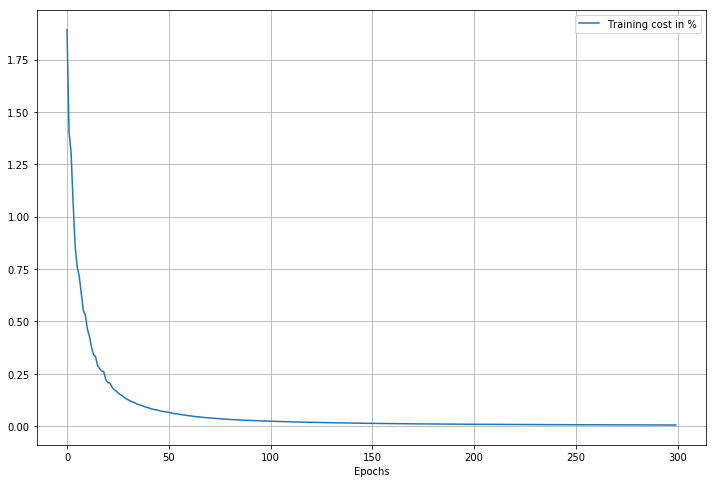

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(t_cost, label='Training cost')
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

1000
10000


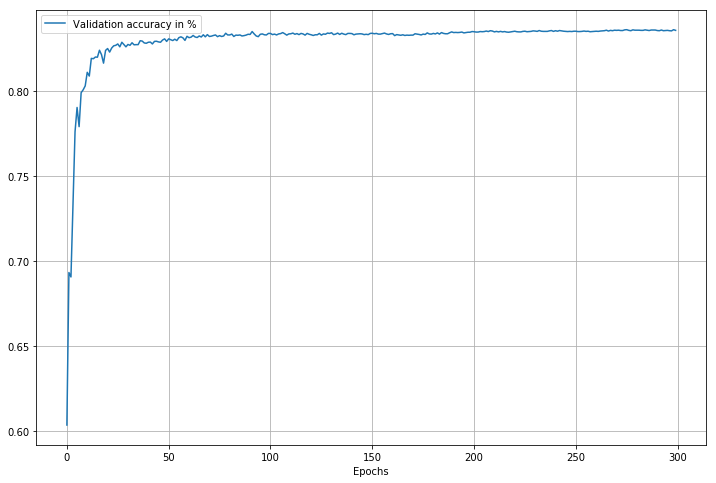

In [36]:
print(len(short_training_data))
print(len(test_data))
t_relative_accuracy = np.array(t_accuracy, dtype=float) / len(short_training_data) 
e_relative_accuracy = np.array(e_accuracy, dtype=float) / len(test_data) 

plt.figure(figsize=(12, 8))
# plt.plot(t_relative_accuracy, label='Training accuracy in %')
plt.plot(e_relative_accuracy, label='Validation accuracy in %')
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

Using the results from the training, generate one plot with training accuracy vs epochs and one with test cost vs epochs. How do these plots relate to the ones from the previous points? In particular, compare cost on the training data with  cost on the test data, and classification accuracy on both the training data and the the test data. Are they also confirming the hypothesis of overfitting? And, if so, how? 

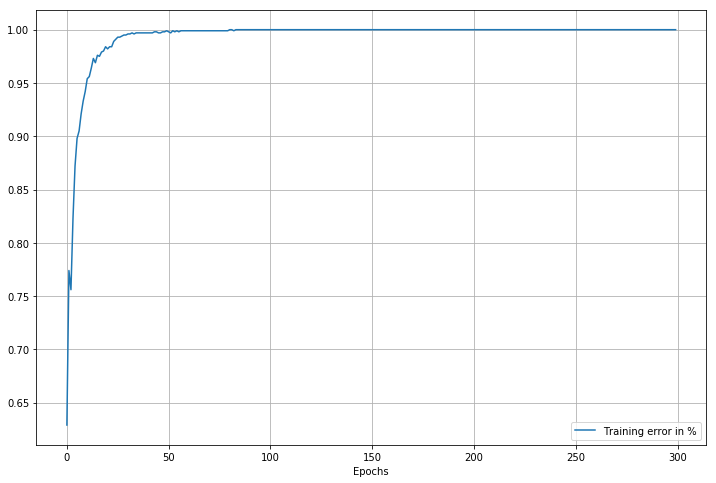

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(t_relative_accuracy, label='Training accuracy in %')
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

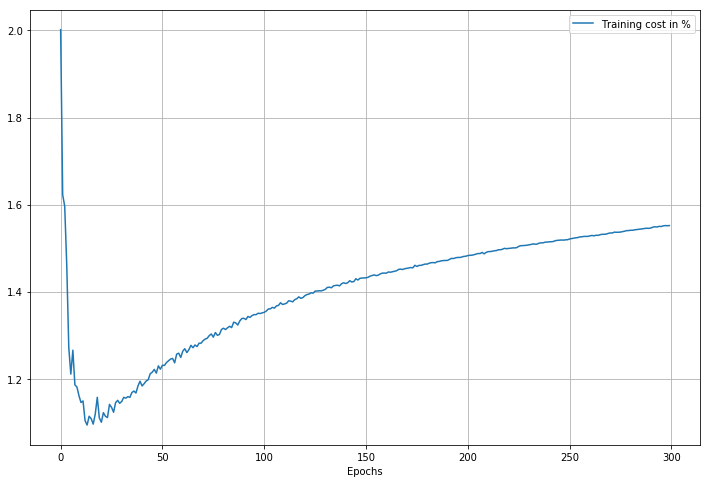

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(e_cost, label='Training cost')
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

The training accuracy reaches a near perfect level of 999/1000 after about 50 epochs and 1000/1000 after ~100 epochs.
Meanwhile the cost of the test data decreases sharply during the first 20 epochs, and starts to increase from that level. This clearly supports the hypothesis of overfitting. 

This demonstrates, that a small dataset is easy to fit, but generalises poorly. 